In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from timm import create_model
import cv2
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=1024
class_list=['NT_epithelial','NT_immune','NT_stroma','TP_in_situ','TP_invasive']
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [3]:
img_path='../../data/area_segmentation/BRID/image/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/image/','/mask/') for i in img_list]
mask_list=[i.replace('.jpeg','.npy') for i in mask_list]
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(img_list,mask_list,test_size=0.2,random_state=42)

test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)
np_mask=np.zeros((img_size,img_size,len(class_list)))
for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(Image.open(train_img_list[i]))
    np_mask=np.load(train_mask_list[i]).astype(np.uint8)
    for j in range(3):
        train_mask[i,j+1]=tf(np_mask[...,j]/255.)
    train_mask[i,4]=tf(np_mask[...,3]/255.)
    train_mask[i,5]=tf(np_mask[...,4]/255.)
    train_mask[i,0]=1-train_mask[i,1:len(class_list)+1].sum(0)
for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(Image.open(test_img_list[i]))
    np_mask=np.load(test_mask_list[i]).astype(np.uint8)
    for j in range(3):
        test_mask[i,j+1]=tf(np_mask[...,j]/255.)
    test_mask[i,4]=tf(np_mask[...,3]/255.)
    test_mask[i,5]=tf(np_mask[...,4]/255.)
    test_mask[i,0]=1-test_mask[i,1:len(class_list)+1].sum(0)

100%|██████████| 90/90 [01:04<00:00,  1.39it/s]


In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path,label_path = self.img_path[idx],self.label[idx]

        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

test_dataset = CustomDataset(test_image, test_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
model = smp.MAnet(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=len(class_list)+1,                      # model output channels (number of classes in your dataset) 
    ).to(device)
def dice_loss(pred, target, num_classes=len(class_list)+1):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)
            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()

# summary(model,(batch_size,3,img_size,img_size))

epoch: 1/1000 Step: 179 dice_loss : 0.7336 dice_score: 0.2664: 100%|██████████| 178/178 [01:18<00:00,  2.25it/s]
test epoch: 1/1000 Step: 46 dice_loss : 0.6886  dice_score: 0.3114: 100%|██████████| 45/45 [00:06<00:00,  7.24it/s]
epoch: 2/1000 Step: 179 dice_loss : 0.6466 dice_score: 0.3534: 100%|██████████| 178/178 [01:24<00:00,  2.12it/s]
test epoch: 2/1000 Step: 46 dice_loss : 0.6316  dice_score: 0.3684: 100%|██████████| 45/45 [00:15<00:00,  2.96it/s]
epoch: 3/1000 Step: 179 dice_loss : 0.6198 dice_score: 0.3802: 100%|██████████| 178/178 [01:30<00:00,  1.97it/s]
test epoch: 3/1000 Step: 46 dice_loss : 0.6127  dice_score: 0.3873: 100%|██████████| 45/45 [00:06<00:00,  6.50it/s]
epoch: 4/1000 Step: 179 dice_loss : 0.5986 dice_score: 0.4014: 100%|██████████| 178/178 [01:20<00:00,  2.21it/s]
test epoch: 4/1000 Step: 46 dice_loss : 0.5933  dice_score: 0.4067: 100%|██████████| 45/45 [00:07<00:00,  6.39it/s]
epoch: 5/1000 Step: 179 dice_loss : 0.5906 dice_score: 0.4094: 100%|██████████| 178/

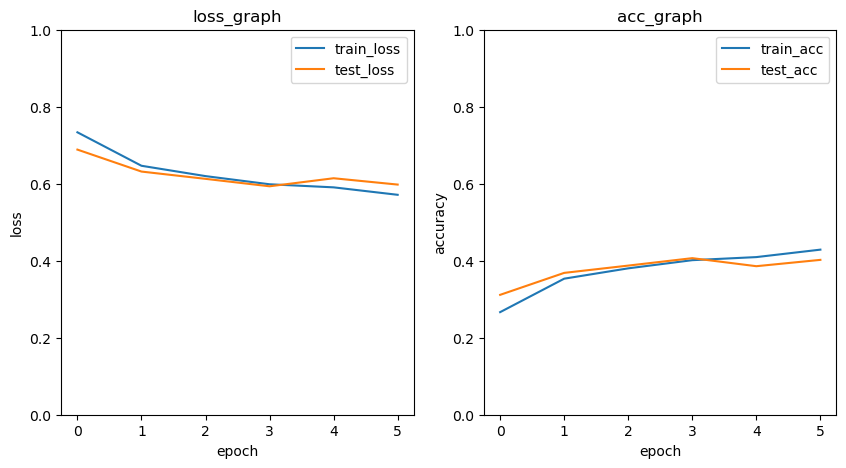

epoch: 7/1000 Step: 179 dice_loss : 0.5609 dice_score: 0.4391: 100%|██████████| 178/178 [01:21<00:00,  2.17it/s]
test epoch: 7/1000 Step: 46 dice_loss : 0.6001  dice_score: 0.3999: 100%|██████████| 45/45 [00:06<00:00,  6.47it/s]
epoch: 8/1000 Step: 179 dice_loss : 0.5478 dice_score: 0.4522: 100%|██████████| 178/178 [01:21<00:00,  2.17it/s]
test epoch: 8/1000 Step: 46 dice_loss : 0.5888  dice_score: 0.4112: 100%|██████████| 45/45 [00:06<00:00,  7.48it/s]
epoch: 9/1000 Step: 179 dice_loss : 0.5422 dice_score: 0.4578: 100%|██████████| 178/178 [01:23<00:00,  2.14it/s]
test epoch: 9/1000 Step: 46 dice_loss : 0.5880  dice_score: 0.4120: 100%|██████████| 45/45 [00:06<00:00,  6.51it/s]
epoch: 10/1000 Step: 179 dice_loss : 0.5344 dice_score: 0.4656: 100%|██████████| 178/178 [01:24<00:00,  2.10it/s]
test epoch: 10/1000 Step: 46 dice_loss : 0.5805  dice_score: 0.4195: 100%|██████████| 45/45 [00:06<00:00,  7.16it/s]
epoch: 11/1000 Step: 179 dice_loss : 0.5180 dice_score: 0.4820: 100%|██████████| 1

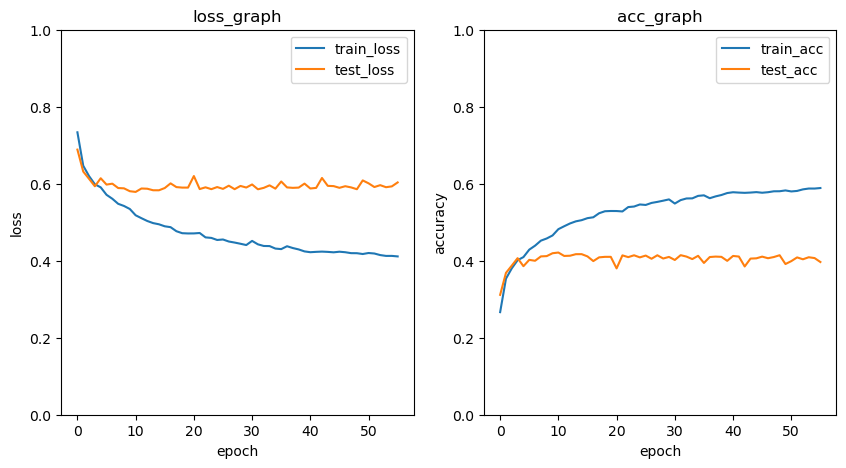

epoch: 57/1000 Step: 179 dice_loss : 0.4157 dice_score: 0.5843: 100%|██████████| 178/178 [01:18<00:00,  2.26it/s]
test epoch: 57/1000 Step: 46 dice_loss : 0.6211  dice_score: 0.3789: 100%|██████████| 45/45 [00:05<00:00,  7.57it/s]
epoch: 58/1000 Step: 179 dice_loss : 0.4268 dice_score: 0.5732: 100%|██████████| 178/178 [01:19<00:00,  2.25it/s]
test epoch: 58/1000 Step: 46 dice_loss : 0.5952  dice_score: 0.4048: 100%|██████████| 45/45 [00:06<00:00,  7.24it/s]
epoch: 59/1000 Step: 179 dice_loss : 0.4190 dice_score: 0.5810: 100%|██████████| 178/178 [01:19<00:00,  2.25it/s]
test epoch: 59/1000 Step: 46 dice_loss : 0.6030  dice_score: 0.3970: 100%|██████████| 45/45 [00:06<00:00,  7.48it/s]
epoch: 60/1000 Step: 179 dice_loss : 0.4128 dice_score: 0.5872: 100%|██████████| 178/178 [01:18<00:00,  2.28it/s]
test epoch: 60/1000 Step: 46 dice_loss : 0.5961  dice_score: 0.4039: 100%|██████████| 45/45 [00:06<00:00,  7.17it/s]
epoch: 61/1000 Step: 179 dice_loss : 0.4139 dice_score: 0.5861: 100%|███████

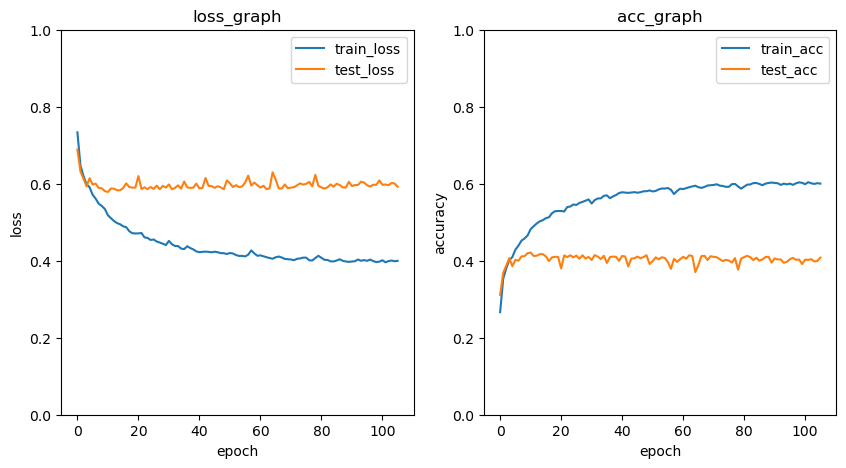

epoch: 107/1000 Step: 179 dice_loss : 0.3938 dice_score: 0.6062: 100%|██████████| 178/178 [01:20<00:00,  2.21it/s]
test epoch: 107/1000 Step: 46 dice_loss : 0.5940  dice_score: 0.4060: 100%|██████████| 45/45 [00:06<00:00,  7.28it/s]
epoch: 108/1000 Step: 179 dice_loss : 0.3933 dice_score: 0.6067: 100%|██████████| 178/178 [01:18<00:00,  2.26it/s]
test epoch: 108/1000 Step: 46 dice_loss : 0.5914  dice_score: 0.4086: 100%|██████████| 45/45 [00:06<00:00,  7.20it/s]
epoch: 109/1000 Step: 158 dice_loss : 0.3909 dice_score: 0.6091:  88%|████████▊ | 157/178 [01:10<00:09,  2.24it/s]


KeyboardInterrupt: 

In [7]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y) # cost 구함
        acc=1-cost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/areaSeg/BR_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%50==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')